In [413]:
from datetime import datetime
from scipy.stats import skew,norm  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.stats as stats
from scipy import stats
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

#ML Algoirthm
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor

In [414]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_size = train.shape[0]
submission = pd.read_csv("sample_submission.csv")

In [415]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


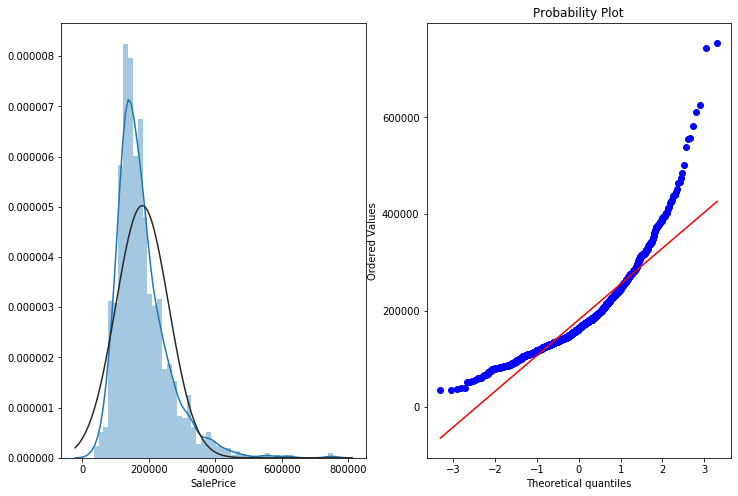

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [416]:
#Saleprice is the target variable. Lets analyse its distribution
f,ax = plt.subplots(1,2,figsize=(12,8))
sns.distplot(train['SalePrice'],ax=ax[0],fit=norm)
stats.probplot(train['SalePrice'],plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(train['SalePrice'].skew()))
print("Kurtosis: {}".format(train['SalePrice'].kurt()))

In [417]:
#target variable is rightly skewed. Lets apply log and make it normally distributed

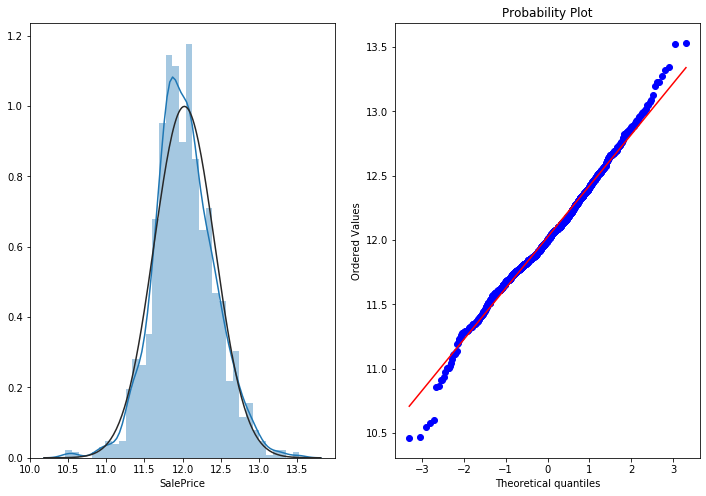

Skewness: 0.12134661989685333
Kurtosis: 0.809519155707878


In [418]:
#Log- transformation
y = np.log1p(train['SalePrice'])

f,ax = plt.subplots(1,2,figsize=(12,8))
sns.distplot(y,fit=norm,ax=ax[0])
stats.probplot(y,plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(y.skew()))
print("Kurtosis: {}".format(y.kurt()))

In [419]:
# feature visualization with target variable
# * outlier detection
# * correlation

# removableColumns tracks the columns to be removed. Action will be performed a bit later.

In [420]:
# this function returns the numeric columns
def getNumericField(all_dataset,skipCol):
    return list(filter(lambda x:x not in skipCol , all_dataset.select_dtypes(exclude='object').columns))

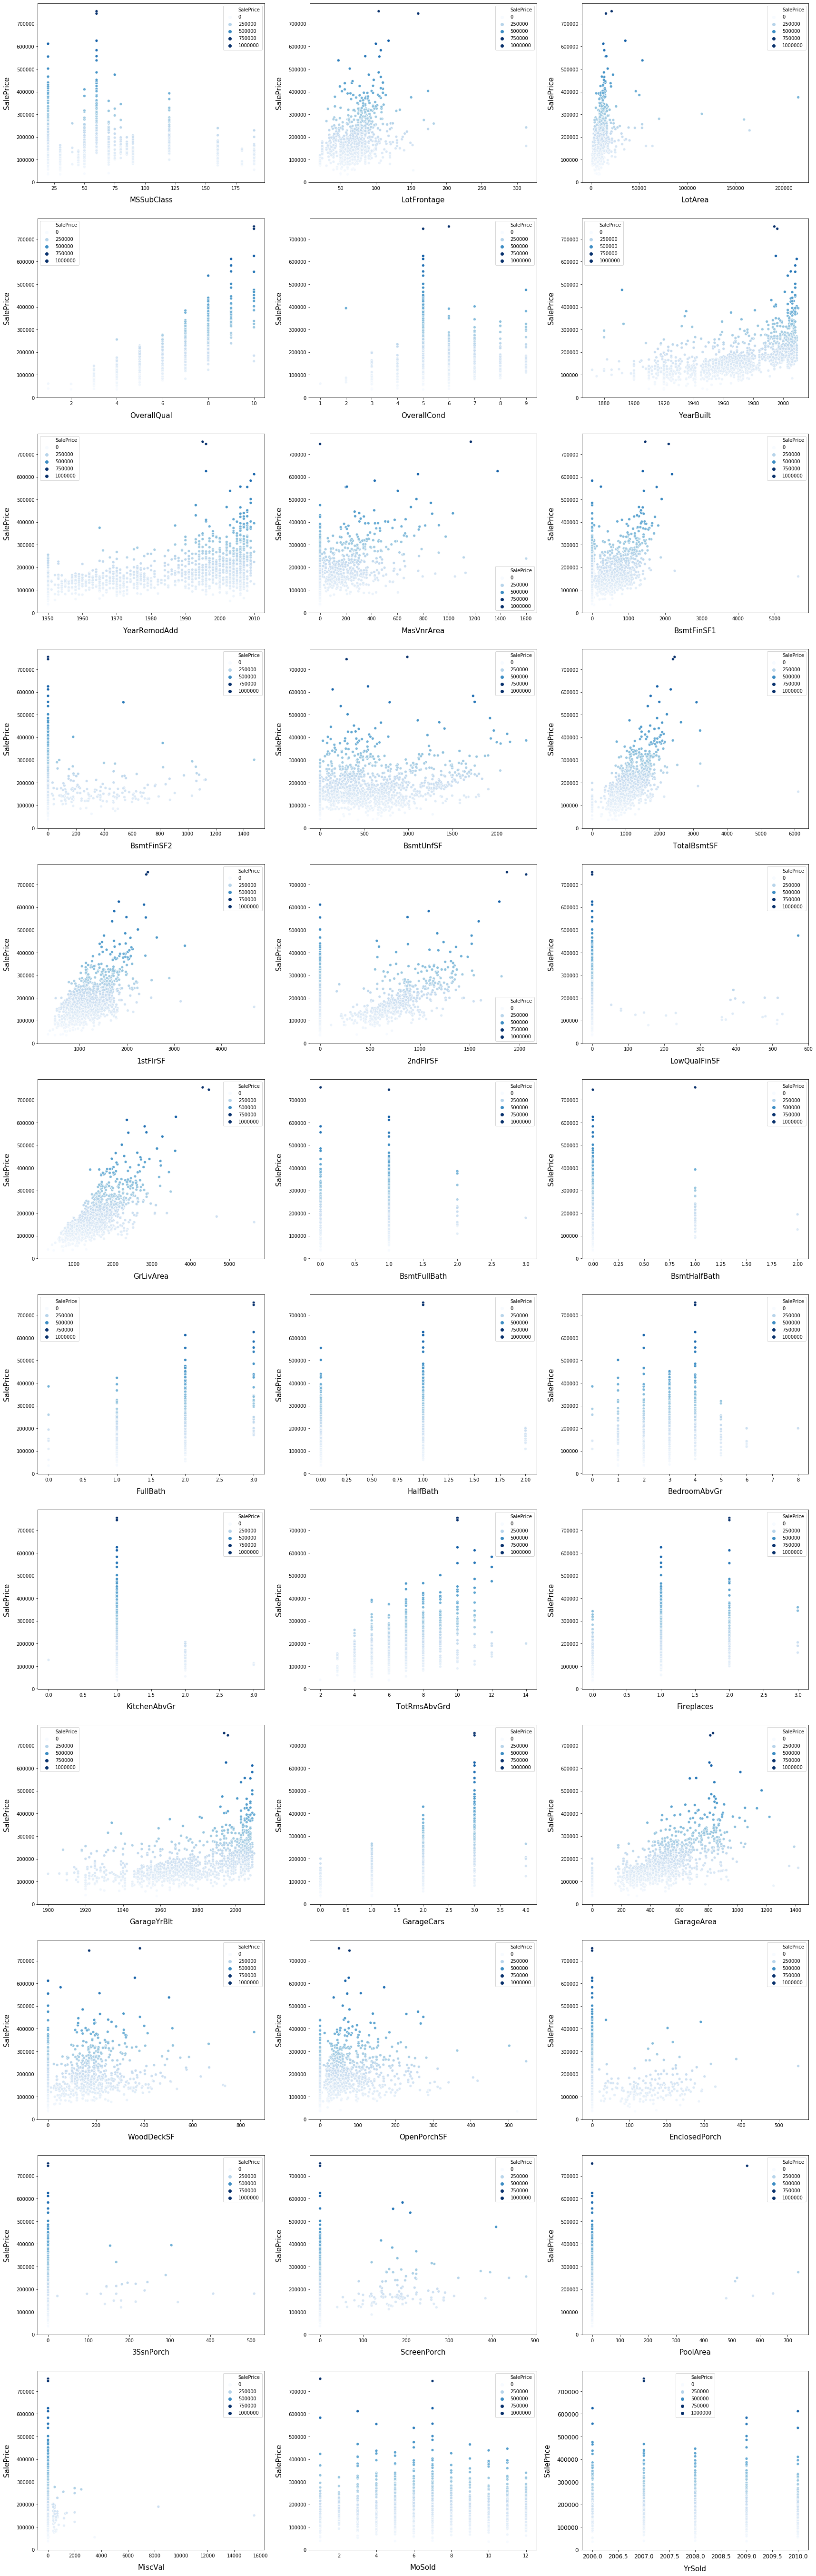

In [421]:
skipCol = ['Id','SalePrice']
numeric = getNumericField(train,skipCol)
n_rows = round(len(numeric_cols)/3)
# def visWithSalePrice(all_dataset,target):
#     fig, axs = plt.subplots(ncols=3, nrows = n_rows, figsize=(12, 60))
#     plt.subplots_adjust(right=2)
#     plt.subplots_adjust(top=2)
#     row = 0
#     column = 0
#     for i,col in enumerate(numeric_cols):
#         axs[row,column].scatter(train[col],train['SalePrice'])
#         axs[row,column].set_xlabel(col, labelpad=15,fontsize=15)
#         axs[row,column].set_ylabel("SalePrice", labelpad=15,fontsize=15)
#         column += 1
#         if column > 2:
#             column = 0
#             row += 1
#     plt.show()

def visWithSalePrice(all_dataset,target):
    fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=2)
    for i, feature in enumerate(list(train[numeric]), 1):
        plt.subplot(len(list(numeric)), 3, i)
        sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
        plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
        plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
    plt.show()
visWithSalePrice(train,'SalePrice')


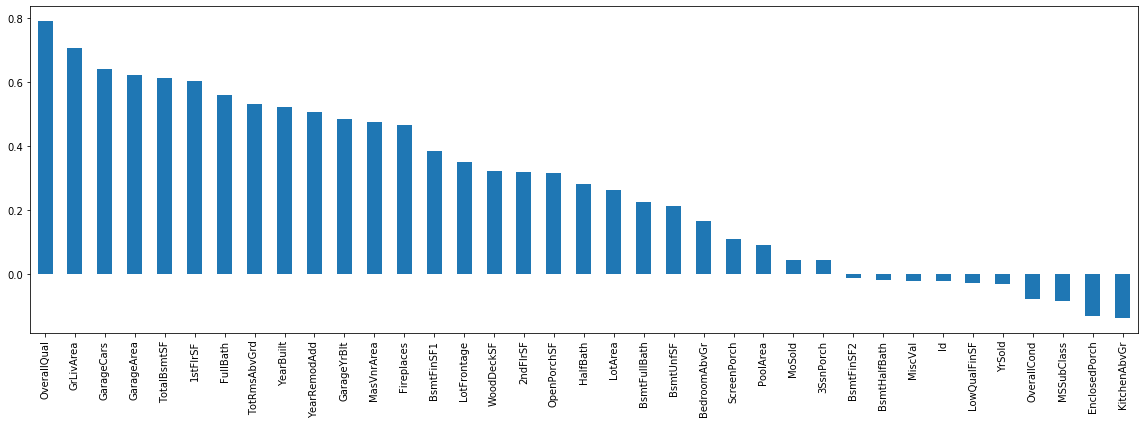

In [422]:
corr = train.select_dtypes(include='number').corr()
plt.figure(figsize=(16,6))
corr['SalePrice'].sort_values(ascending=False)[1:].plot(kind='bar')
plt.tight_layout()

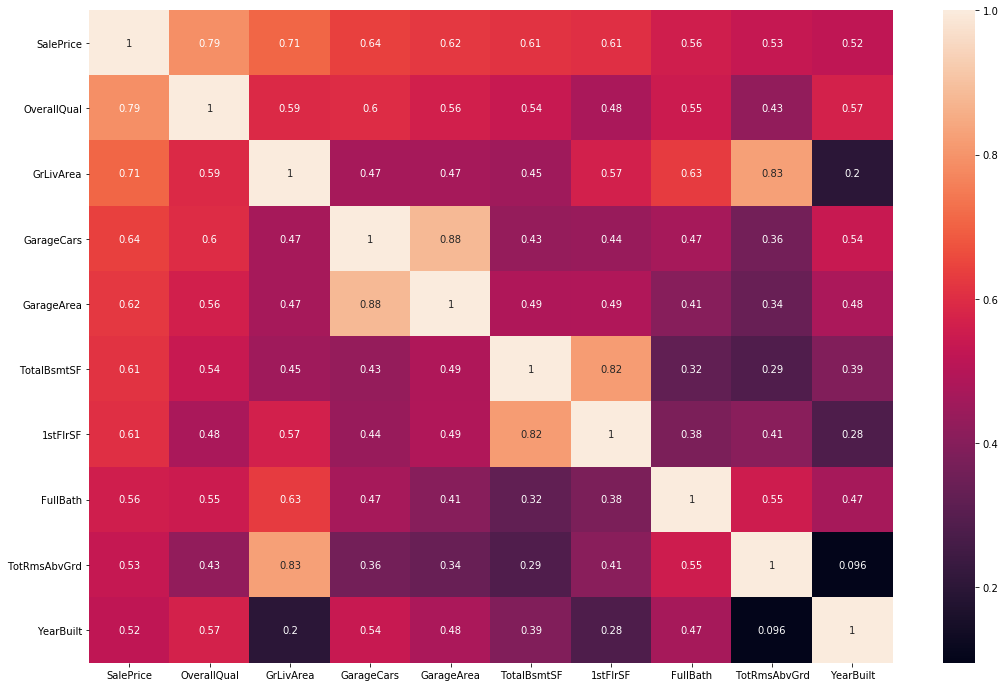

In [423]:
corWithSalePrice = corr.nlargest(10,'SalePrice')['SalePrice'].index
f , ax = plt.subplots(figsize = (18,12))
ax = sns.heatmap(train[corWithSalePrice].corr(), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

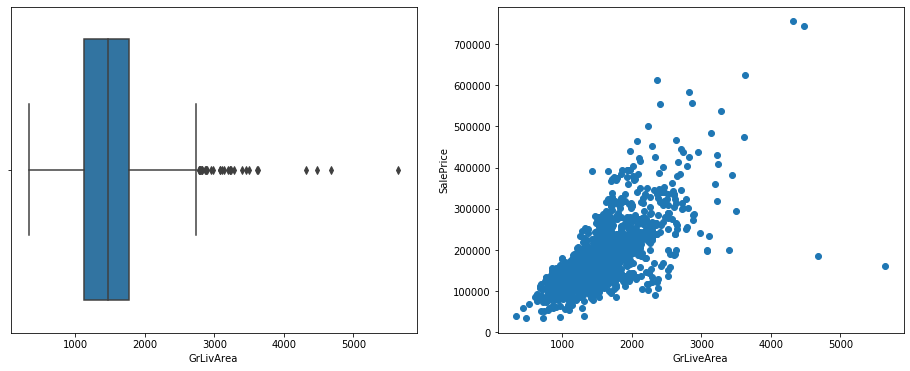

In [424]:
f,ax = plt.subplots(1,2,figsize=(16,6))
sns.boxplot(train['GrLivArea'],ax=ax[0])
plt.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel('GrLiveArea')
plt.ylabel('SalePrice')
plt.show()


In [425]:
train.drop(train[train['GrLivArea']>4000].index,axis=0,inplace=True)


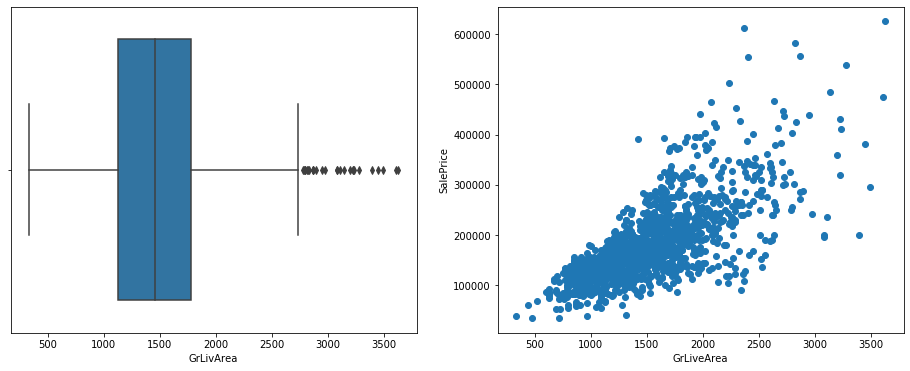

In [426]:
f,ax = plt.subplots(1,2,figsize=(16,6))
sns.boxplot(train['GrLivArea'],ax=ax[0])
plt.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel('GrLiveArea')
plt.ylabel('SalePrice')
plt.show()

In [427]:
# Combine train and test for Data preprocessing and feature transformation
# removing saleprice from train all_dataset. Since it is the target variable
train.drop(['Id','SalePrice'],inplace=True,axis=1)
test.drop('Id',inplace=True,axis=1)
all_dataset = pd.concat([train,test]).reset_index(drop=True)
all_dataset.shape

(2915, 79)

In [428]:
# Missing Data

In [429]:
missing_value = all_dataset.isnull().sum().sort_values(ascending=False) / len(all_dataset) * 100
missing_value = missing_value[missing_value != 0]
missing_value = pd.DataFrame({'Missing value' :missing_value,'Type':missing_value.index.map(lambda x:all_dataset[x].dtype)})
missing_value[:10]

,Missing value,Type
PoolQC,99.725557,object
MiscFeature,96.397942,object
Alley,93.207547,object
Fence,80.445969,object
FireplaceQu,48.713551,object
LotFrontage,16.672384,float64
GarageCond,5.454545,object
GarageQual,5.454545,object
GarageYrBlt,5.454545,float64
GarageFinish,5.454545,object


In [430]:
for col in ['PoolQC','Street','Utilities']:
    value_counts = all_dataset[col].value_counts(dropna=False)
    print(value_counts)
    print("Occupancy of single type is {}".format(value_counts[0]/sum(value_counts) * 100))
    print("----------------------------------------------")

NaN    2907
Gd        3
Ex        3
Fa        2
Name: PoolQC, dtype: int64
Occupancy of single type is 99.72555746140652
----------------------------------------------
Pave    2903
Grvl      12
Name: Street, dtype: int64
Occupancy of single type is 99.58833619210978
----------------------------------------------
AllPub    2912
NaN          2
NoSeWa       1
Name: Utilities, dtype: int64
Occupancy of single type is 99.89708404802744
----------------------------------------------


In [431]:
all_dataset.drop(['PoolQC','Street','Utilities'],inplace=True,axis=1)

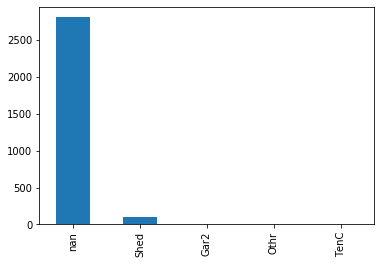

In [432]:
pd.value_counts(all_dataset['MiscFeature'],dropna=False).plot(kind="bar")
all_dataset['MiscFeature'].fillna("None",inplace=True)

In [433]:
fillMissingValOnCol = ['Alley','Fence','FireplaceQu','GarageQual','GarageCond','GarageFinish','GarageType','BsmtCond', 
                       'BsmtExposure', 'BsmtQual','BsmtFinType1','BsmtFinType2','MasVnrType','KitchenQual','Exterior2nd','Exterior1st','SaleType','Electrical']

for col in fillMissingValOnCol:
    all_dataset[col].fillna('None',inplace=True)

In [434]:
all_dataset['LotFrontage'] = all_dataset.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.mean()))

In [435]:
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars','BsmtHalfBath','BsmtFullBath','BsmtUnfSF','BsmtFinSF2','MasVnrArea' ,'BsmtFinSF1','Functional']:
    all_dataset[col] = all_dataset[col].fillna(0)

In [436]:
TotalBSMT = all_dataset[all_dataset['TotalBsmtSF'].isnull()]
print(TotalBSMT[['BsmtFinType1','BsmtFinType2']])
all_dataset['TotalBsmtSF'].fillna(0,inplace=True)


     BsmtFinType1 BsmtFinType2
2116         None         None


In [437]:
# all_dataset['Functional'].fillna('Typ',inplace=True)

In [438]:
# fillSaleType = all_dataset[all_dataset['SaleCondition'] == 'Normal']['SaleType'].mode()[0]
# all_dataset['SaleType'].fillna(fillSaleType,inplace=True)

# fillElectrical = all_dataset[all_dataset['Neighborhood']=='Timber']['Electrical'].mode()[0]
# all_dataset['Electrical'].fillna(fillElectrical,inplace=True)

# exterior1_neighbor = all_dataset[all_dataset['Exterior1st'].isnull()]['Neighborhood'].values[0]
# fillExterior1 = all_dataset[all_dataset['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
# all_dataset['Exterior1st'].fillna(fillExterior1,inplace=True)

# exterior2_neighbor = all_dataset[all_dataset['Exterior2nd'].isnull()]['Neighborhood'].values[0]
# fillExterior2 = all_dataset[all_dataset['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
# all_dataset['Exterior2nd'].fillna(fillExterior2,inplace=True)

# bsmtNeigh = all_dataset[all_dataset['BsmtFinSF1'].isnull()]['Neighborhood'].values[0]
# fillBsmtFinSf1 = all_dataset[all_dataset['Neighborhood'] == bsmtNeigh]['BsmtFinSF1'].mode()[0]
# all_dataset['BsmtFinSF1'].fillna(fillBsmtFinSf1,inplace=True)

# kitchen_grade = all_dataset[all_dataset['KitchenQual'].isnull()]['KitchenAbvGr'].values[0]
# fillKitchenQual = all_dataset[all_dataset['KitchenAbvGr'] == kitchen_grade]['KitchenQual'].mode()[0]
# all_dataset['KitchenQual'].fillna(fillKitchenQual,inplace=True)

In [439]:
# MSSubClass Identifies the type of dwelling involved in the sale. so this should be converted to string
all_dataset['MSSubClass'] = all_dataset['MSSubClass'].astype(str)

In [440]:
all_dataset['MSZoning'] = all_dataset.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [441]:
# # Some of the categorical feature are ordered 
# quality_map = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
# quality_cols = ['BsmtQual', 'BsmtCond','ExterQual', 'ExterCond','FireplaceQu','GarageQual', 'GarageCond','KitchenQual','HeatingQC']
# for col in quality_cols:
#     all_dataset[col] = all_dataset[col].replace(quality_map)


In [442]:
# all_dataset['BsmtExposure'] = all_dataset['BsmtExposure'].replace({"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3})

# all_dataset["PavedDrive"] =all_dataset["PavedDrive"].replace({"N" : 0, "P" : 1, "Y" : 2})

# bsmt_ratings = {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
# bsmt_col = ['BsmtFinType1','BsmtFinType2']
# for col in bsmt_col:
#     all_dataset[col] = all_dataset[col].replace(bsmt_ratings)



In [443]:
sum(all_dataset.isnull().sum().sort_values(ascending=False) > 0)

0

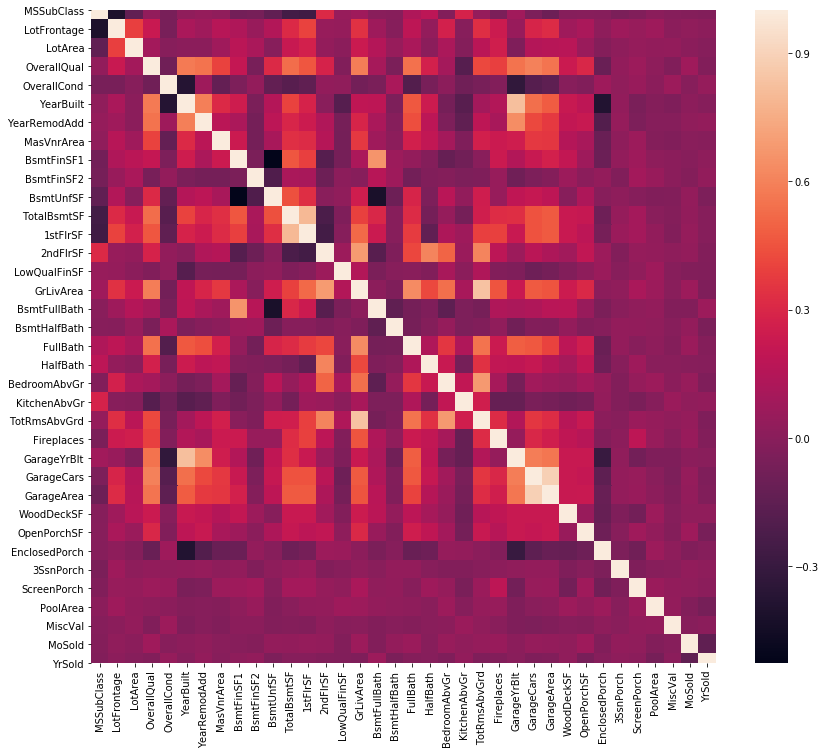

In [444]:
corr = train.corr()
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(corr,ax=ax)
plt.show()

In [445]:
print("GrLiveArea is strongly correleated with {}".format(corr['GrLivArea'].sort_values(ascending=False).index[1]))
print("YearBuilt is strongly correleated with {}".format(corr['YearBuilt'].sort_values(ascending=False).index[1]))
print("GarageArea is strongly correleated with {}".format(corr['GarageArea'].sort_values(ascending=False).index[1]))
print("TotalBsmtSF is strongly correleated with {}".format(corr['TotalBsmtSF'].sort_values(ascending=False).index[1]))

GrLiveArea is strongly correleated with TotRmsAbvGrd
YearBuilt is strongly correleated with GarageYrBlt
GarageArea is strongly correleated with GarageCars
TotalBsmtSF is strongly correleated with 1stFlrSF


In [446]:
#we keep 'GrLiveArea , GarageCars , TotalBsmtSF , YearBuilt , 1stFflrSF(need for feature generation). Since this features are 
# highly correleated with SalePrice than the removable features
all_dataset.drop(['TotRmsAbvGrd','GarageYrBlt','GarageArea'],inplace=True,axis=1)

In [447]:
# Feature Creation

In [448]:
all_dataset['TotalSpace'] = all_dataset['OpenPorchSF'] + all_dataset['3SsnPorch'] + all_dataset['EnclosedPorch'] + all_dataset['ScreenPorch']  + all_dataset['WoodDeckSF']

In [449]:
all_dataset['Total_Porch_Area'] = all_dataset[['OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF']].sum(axis=1)


In [450]:
all_dataset['Total_Space_Sf'] = all_dataset[['TotalBsmtSF','1stFlrSF','2ndFlrSF']].sum(axis=1)
all_dataset['Total_Bsmt_Sf'] = all_dataset[['BsmtFinSF1','BsmtFinSF2']].sum(axis=1)

In [451]:
all_dataset['TotalBathroom'] = all_dataset['BsmtFullBath']+all_dataset['BsmtHalfBath']+all_dataset['FullBath']*0.5 + all_dataset['HalfBath']*0.5

In [452]:
# houseAge = all_dataset['YrSold'] - all_dataset['YearBuilt']
# rebuildAge = all_dataset['YearRemodAdd'] - all_dataset['YearBuilt'] 
# f,ax = plt.subplots(1,2,figsize=(12,8))
# # We can see that new house is selling at the higher price 
# all_dataset['HseAgeBin'] = pd.cut(houseAge.astype(int), 5)
# all_dataset['HseAgeBin'].value_counts().plot(kind='bar',ax=ax[0])
# ax[0].set_xlabel('House Age')


# all_dataset['HseRebuildBin'] = pd.cut(rebuildAge.astype(int), 5)
# all_dataset['HseRebuildBin'].value_counts().plot(kind='bar')
# ax[1].set_xlabel('Time taken to Rebuild')
# plt.show()

# all_dataset.drop(['YearBuilt','YrSold','YearRemodAdd'],inplace=True,axis=1)

In [453]:
print(all_dataset['MiscFeature'].value_counts())
all_dataset['HasMiscFeature'] = all_dataset['MiscFeature'].apply(lambda x : 0 if x == 'None' else 1)

print(all_dataset['PoolArea'].value_counts())
all_dataset['HasPool'] = all_dataset['PoolArea'].apply(lambda x : 0 if x == 0 else 1)

print(all_dataset['Alley'].value_counts())
all_dataset['HasAlleyAccess'] = all_dataset['Alley'].apply(lambda x : 0 if x == 'None' else 1)

print(all_dataset['MasVnrType'].value_counts())
all_dataset['HasMasVnr'] = all_dataset['MasVnrType'].apply(lambda x : 0 if x == 'None' else 1)

print(all_dataset['MSZoning'].value_counts())
all_dataset['HasRLzoning'] = all_dataset['MSZoning'].apply(lambda x : 1 if x == 'RL' else 0)

print(all_dataset['Condition2'].value_counts())
all_dataset['IsCondition2Norm'] = all_dataset['Condition2'].apply(lambda x : 1 if x == 'Norm' else 0)

print(all_dataset['SaleCondition'].value_counts())
all_dataset['HasNormalSaleCondition'] = all_dataset['SaleCondition'].apply(lambda x : 1 if x == 'Normal' else 0)

all_dataset['Condition1&2'] = all_dataset['Condition1'] == all_dataset['Condition2']


None    2810
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64
0      2904
561       1
519       1
800       1
738       1
648       1
576       1
512       1
444       1
368       1
228       1
144       1
Name: PoolArea, dtype: int64
None    2717
Grvl     120
Pave      78
Name: Alley, dtype: int64
None       1765
BrkFace     878
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64
RL         2263
RM          462
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
Norm      2886
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64
Normal     2401
Partial     243
Abnorml     189
Family       46
Alloca       24
AdjLand      12
Name: SaleCondition, dtype: int64


In [454]:
# all_dataset['MoSoldBin'] = pd.cut(all_dataset['MoSold'].astype(int), 4)
# ax = all_dataset['MoSoldBin'].value_counts().plot(kind='bar')
# ax.set_xlabel('Month sold Bin')
# plt.show()
# all_dataset.drop('MoSold',inplace=True,axis=1)


In [456]:
# label = LabelEncoder()
# all_dataset['HseAgeBin'] = label.fit_transform(all_dataset['HseAgeBin']).astype(str)
# all_dataset['HseRebuildBin'] = label.fit_transform(all_dataset['HseRebuildBin']).astype(str)
# all_dataset['MoSoldBin'] = label.fit_transform(all_dataset['MoSoldBin']).astype(str)

In [457]:
# all_dataset['OverallGrade'] = all_dataset['OverallQual'] * all_dataset['OverallCond']
# all_dataset['ExterGrade'] = all_dataset['ExterQual'] * all_dataset['ExterCond']
# all_dataset["GarageGrade"] = all_dataset["GarageQual"] * all_dataset["GarageCond"]
# all_dataset['BsmtGrade'] = all_dataset['BsmtQual'] * all_dataset['BsmtCond']
# all_dataset['BsmtFinTypeGrade'] = all_dataset['BsmtFinType1'] * all_dataset['BsmtFinType2']
# all_dataset["KitchenScore"] = all_dataset["KitchenAbvGr"] * all_dataset["KitchenQual"]
# all_dataset["FireplaceScore"] = all_dataset["Fireplaces"] * all_dataset["FireplaceQu"]
# all_dataset["GarageScore"] = all_dataset["GarageArea"] * all_dataset["GarageQual"]

In [458]:
all_dataset.select_dtypes(include=['object']).nunique().sort_values()

CentralAir        2
LandSlope         3
PavedDrive        3
Alley             3
LotShape          4
LandContour       4
ExterQual         4
MasVnrType        4
GarageFinish      4
KitchenQual       5
BsmtCond          5
HeatingQC         5
BsmtExposure      5
ExterCond         5
Fence             5
MiscFeature       5
MSZoning          5
LotConfig         5
BldgType          5
BsmtQual          5
GarageQual        6
FireplaceQu       6
GarageCond        6
Electrical        6
Heating           6
SaleCondition     6
Foundation        6
RoofStyle         6
BsmtFinType1      7
GarageType        7
RoofMatl          7
BsmtFinType2      7
Functional        8
HouseStyle        8
Condition2        8
Condition1        9
SaleType         10
Exterior1st      16
MSSubClass       16
Exterior2nd      17
Neighborhood     25
dtype: int64

In [459]:
all_dataset.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'Poo

In [460]:
numeric_col = all_dataset.select_dtypes(exclude=['object']).columns

In [461]:
# Find skewed numerical features
skew_features = all_dataset[numeric_col].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
skew_features

MiscVal                   21.932147
PoolArea                  18.701829
HasPool                   16.186531
LotArea                   13.123758
LowQualFinSF              12.080315
3SsnPorch                 11.368094
HasMiscFeature             4.979887
KitchenAbvGr               4.298845
BsmtFinSF2                 4.142863
EnclosedPorch              4.000796
ScreenPorch                3.943508
BsmtHalfBath               3.942892
HasAlleyAccess             3.434399
MasVnrArea                 2.600697
OpenPorchSF                2.529245
WoodDeckSF                 1.848285
Total_Porch_Area           1.381605
TotalSpace                 1.381605
1stFlrSF                   1.253011
LotFrontage                1.049188
GrLivArea                  0.977860
BsmtFinSF1                 0.974138
Total_Space_Sf             0.936173
BsmtUnfSF                  0.920135
2ndFlrSF                   0.843237
Total_Bsmt_Sf              0.791245
Fireplaces                 0.725958
HalfBath                   0

In [462]:
for i in skew_index:
    all_dataset[i] = boxcox1p(all_dataset[i], boxcox_normmax(all_dataset[i] + 1))
skew_features_add = all_dataset[numeric_col].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew_features_add

C:\Users\john\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\john\Anaconda3\lib\site-packages\scipy\stats\stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


PoolArea                  16.290037
HasPool                   16.186531
3SsnPorch                  8.858944
LowQualFinSF               8.489627
MiscVal                    5.236070
HasMiscFeature             4.979887
BsmtHalfBath               3.790877
KitchenAbvGr               3.776776
HasAlleyAccess             3.434399
ScreenPorch                3.151351
BsmtFinSF2                 2.577190
EnclosedPorch              2.148107
MasVnrArea                 0.977442
2ndFlrSF                   0.892739
WoodDeckSF                 0.786377
HalfBath                   0.734482
OpenPorchSF                0.621703
BsmtFullBath               0.616950
Fireplaces                 0.553409
HasMasVnr                  0.431672
Total_Bsmt_Sf              0.391339
OverallCond                0.382277
BsmtFinSF1                 0.365567
BedroomAbvGr               0.328129
TotalBsmtSF                0.295280
MoSold                     0.198411
TotalSpace                 0.187036
Total_Porch_Area           0

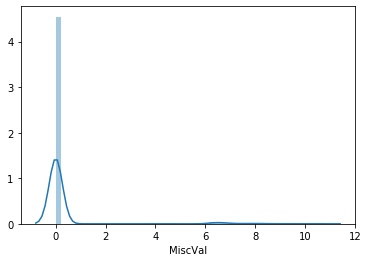

In [463]:
sns.distplot(all_dataset['MiscVal'])


In [464]:
all_dataset.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'Poo

In [465]:
all_dataset =  pd.get_dummies(all_dataset,drop_first=True)


In [466]:
overfit = []
for i in all_dataset.columns:
    counts = all_dataset[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(all_dataset) * 100 > 99.94:
        overfit.append(i)
all_dataset.drop(overfit,inplace=True,axis=1)

In [467]:
train = all_dataset.iloc[:train_size,:]
test = all_dataset.iloc[train_size:,:]

In [468]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [469]:

# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]


In [470]:
# ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
# elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
# svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [471]:
# gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)   

In [472]:
# lightgbm = LGBMRegressor(objective='regression', 
#                                        num_leaves=4,
#                                        learning_rate=0.01, 
#                                        n_estimators=5000,
#                                        max_bin=200, 
#                                        bagging_fraction=0.75,
#                                        bagging_freq=5, 
#                                        bagging_seed=7,
#                                        feature_fraction=0.2,
#                                        feature_fraction_seed=7,
#                                        verbose=-1,
#                                        )


In [473]:
# xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:linear', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006)

In [474]:
# stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
#                                 meta_regressor=xgboost,
#                                 use_features_in_secondary=True)

In [475]:
# score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(elasticnet)
# print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(svr)
# print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(lightgbm)
# print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(xgboost)
# print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.3847 (0.0362)
 2019-11-09 18:24:53.655533


In [476]:
# X = train
# print('stack_gen')
# stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

# print('elasticnet')
# elastic_model_full_data = elasticnet.fit(X, y)

# print('Lasso')
# lasso_model_full_data = lasso.fit(X, y)

# print('Ridge')
# ridge_model_full_data = ridge.fit(X, y)

# print('Svr')
# svr_model_full_data = svr.fit(X, y)

# print('GradientBoosting')
# gbr_model_full_data = gbr.fit(X, y)

# print('xgboost')
# xgb_model_full_data = xgboost.fit(X, y)

# print('lightgbm')
# lgb_model_full_data = lightgbm.fit(X, y)

In [477]:
# train_labels = y.reset_index(drop=True)
# rf = RandomForestRegressor(n_estimators=1200,
#                           max_depth=15,
#                           min_samples_split=5,
#                           min_samples_leaf=5,
#                           max_features=None,
#                           oob_score=True,
#                           random_state=42)
# print('RandomForest')
# rf_model_full_data = rf.fit(X, train_labels)

In [478]:
# def blended_predictions(X):
#     return ((0.1 * ridge_model_full_data.predict(X)) + \
#             (0.2 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
#             (0.1 * xgb_model_full_data.predict(X)) + \
#             (0.1 * lgb_model_full_data.predict(X)) + \
#             (0.05 * rf_model_full_data.predict(X)) + \
#             (0.35 * stack_gen_model.predict(np.array(X))))

In [479]:
# # Get final precitions from the blended model
# blended_score = rmsle(train_labels, blended_predictions(X))
# # scores['blended'] = (blended_score, 0)
# print('RMSLE score on train data:')
# print(blended_score)

In [480]:
# # Plot the predictions for each model
# sns.set_style("white")
# fig = plt.figure(figsize=(24, 12))

# ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
# for i, score in enumerate(scores.values()):
#     ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

# plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
# plt.xlabel('Model', size=20, labelpad=12.5)
# plt.tick_params(axis='x', labelsize=13.5)
# plt.tick_params(axis='y', labelsize=12.5)

# plt.title('Scores of Models', size=20)

# plt.show()

In [481]:
# submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(test)))

In [482]:
# # Fix outleir predictions
# q1 = submission['SalePrice'].quantile(0.0045)
# q2 = submission['SalePrice'].quantile(0.99)
# submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
# submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
# submission.to_csv("submission_regression1.csv", index=False)

In [483]:
# # Scale predictions
# submission['SalePrice'] *= 1.001619
# submission.to_csv("submission_regression2.csv", index=False)

In [484]:
a = 12
a

12

In [485]:
all_dataset.shape

(2915, 268)